In [2]:
import os
import gc
import sys
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sn
from datetime import datetime
import matplotlib.pyplot as plt
from google.cloud import storage
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

sys.path.append(os.path.dirname(os.getcwd())+'/src')
import get_data
import pipeline_modules
from feature_selection_module import feature_selection
from supervised_models import supervised_models

In [4]:
fs = feature_selection()
print(fs.gen_date)

2022-06-03 17:57:06.493917


---

### Reading input data from cloud storage

Reading training set file:

In [5]:
Xtrain, Xval, ytrain, yval = get_data.get_train_data()

added data/processed/input/after_stix_data/processed/input/after_stix_0.parquet
added data/processed/input/after_stix_data/processed/input/after_stix_1.parquet
added data/processed/input/after_stix_data/processed/input/after_stix_10.parquet
added data/processed/input/after_stix_data/processed/input/after_stix_11.parquet
added data/processed/input/after_stix_data/processed/input/after_stix_12.parquet
added data/processed/input/after_stix_data/processed/input/after_stix_13.parquet
added data/processed/input/after_stix_data/processed/input/after_stix_14.parquet
added data/processed/input/after_stix_data/processed/input/after_stix_15.parquet
added data/processed/input/after_stix_data/processed/input/after_stix_16.parquet
added data/processed/input/after_stix_data/processed/input/after_stix_17.parquet
added data/processed/input/after_stix_data/processed/input/after_stix_18.parquet
added data/processed/input/after_stix_data/processed/input/after_stix_19.parquet
added data/processed/input/aft

In [6]:
df_train = pd.concat([Xtrain, ytrain], axis=1)
df_train.head()

,val_venda_bruta_cupom,qtd_item_venda,val_gross_margin_cupom,val_vend_bruta_mercad,flg_vend_meu_desct,valor_desconto,flag_dev,tipo_promo_0,tipo_promo_1,tipo_promo_2,...,cidade,uf,region,pib_percapita,idade,delta_de_cadastro,ind_email,cadastro_stix,delta_de_stix,target
0,42.160000,4.0,12.219000,42.160000,0.0,0.0,0.0,0.0,0.0,0.0,...,goiania,go,co,29732.0,14974.0,1372.0,NaN,0,NaN,1
1,48.619999,31.0,-8.805000,73.680000,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,NaN,NaN,NaN,1.0,1,39.0,0
2,196.929993,16.0,49.733002,167.459991,0.0,0.0,0.0,0.0,0.0,0.0,...,teresina,pi,ne,16125.0,21698.0,7845.0,NaN,0,NaN,0
3,20.879999,8.0,11.285999,39.620003,0.0,0.0,0.0,0.0,0.0,0.0,...,sao paulo,sp,se,51140.0,18914.0,1741.0,NaN,0,NaN,1
4,21.840000,1.0,5.518000,20.389999,0.0,0.0,0.0,0.0,0.0,0.0,...,sao paulo,sp,se,51140.0,26112.0,8000.0,NaN,0,NaN,1


In [7]:
df_train.to_csv('training_set.csv')

In [10]:
df_train.iloc[0:100].to_csv('gs://gpa-churn/data/processed/train/dataset-0.csv', index=False)

In [4]:
numerical_columns = [
    'val_venda_bruta_cupom',
    'qtd_item_venda',
    'flg_vend_meu_desct',
    'valor_desconto',
    'flag_dev',
    'tipo_promo_0',
    'tipo_promo_1',
    'tipo_promo_2',
    'tipo_promo_3',
    'tipo_promo_4',
    'tipo_promo_5',
    'categoria_0',
    'categoria_1',
    'categoria_2',
    'categoria_3',
    'categoria_4',
    'categoria_5',
    'categoria_6',
    'categoria_7',
    'departamento_0',
    'compras_mes',
    'agg_l3m_val_venda_bruta_cupom',
    'agg_l3m_qtd_item_venda',
    'agg_l3m_flg_vend_meu_desct',
    'agg_l3m_valor_desconto',
    'agg_l3m_flag_dev',
    'agg_l3m_tipo_promo_0',
    'agg_l3m_tipo_promo_1',
    'agg_l3m_tipo_promo_2',
    'agg_l3m_tipo_promo_3',
    'agg_l3m_tipo_promo_4',
    'agg_l3m_tipo_promo_5',
    'agg_l3m_categoria_0',
    'agg_l3m_categoria_1',
    'agg_l3m_categoria_2',
    'agg_l3m_categoria_3',
    'agg_l3m_categoria_4',
    'agg_l3m_categoria_5',
    'agg_l3m_categoria_6',
    'agg_l3m_categoria_7',
    'agg_l3m_departamento_0',
    'agg_l3m_compras_mes',
]

outlier_columns_mean = [
    'pib_percapita',
    'idade',
    'delta_de_cadastro',
    'delta_de_stix'
]

yeojohnson_columns = [
    'val_venda_bruta_cupom',
    'qtd_item_venda',
    'flg_vend_meu_desct',
    'valor_desconto',
    'compras_mes',
    'agg_l3m_val_venda_bruta_cupom',
    'agg_l3m_qtd_item_venda',
    'agg_l3m_flg_vend_meu_desct',
    'agg_l3m_valor_desconto',
    'agg_l3m_compras_mes',
    'pib_percapita',
    'idade',
    'delta_de_cadastro'
]

pipeline = Pipeline([
    ('drop_temporary_columns', pipeline_modules.drop_temporary_columns()),
    ('drop_with_low_variance', pipeline_modules.drop_numerical_with_variance(columns=numerical_columns)),
    ('encode_sex_column', pipeline_modules.encode_sex_column()),
    ('group_rare_regions', pipeline_modules.group_rare_categorical(columns=['region'], threshold=0.002)),
    ('encode_regions', pipeline_modules.encode_categorical(columns=['region'])),
    ('handle_outliers_max', pipeline_modules.outlier_handling(
        columns=numerical_columns, 
        method='gauss', 
        band=2.8, 
        action='max')),
    ('handle_outliers_mean', pipeline_modules.outlier_handling(
        columns=outlier_columns_mean, 
        method='gauss', 
        band=2.5, 
        action='mean')),
    ('handle_negative_values', pipeline_modules.handle_negative_values(columns=numerical_columns)),
    ('fill_missing_numerical_zero', pipeline_modules.fill_na_values_with_zero(
        columns=['ind_email','cadastro_stix','delta_de_cadastro','delta_de_stix'])),
    ('fill_missing_numerical_mean', pipeline_modules.fill_na_values_with_zero(
        columns=['pib_percapita','idade'])),
    ('transform_yeojohnson', pipeline_modules.data_transformation(
        columns=yeojohnson_columns, 
        method='yeojohnson'))
])

Xtrain = pipeline.fit_transform(Xtrain)

Dropped numerical variables: 
 {'flag_dev', 'agg_l3m_flag_dev'}


In [5]:
Xval = pipeline.transform(Xval)

Dropped numerical variables: 
 {'flag_dev', 'agg_l3m_flag_dev'}


In [6]:
fs_pipeline = Pipeline([
    ('select_with_correlation', pipeline_modules.select_with_correlation(
        threshold=0.82, 
        method='recursive',
        objective='classification'))
])

Xtrain = fs_pipeline.fit_transform(Xtrain, ytrain)

# validation set
#-------------------------------------------------------

Xval = fs_pipeline.transform(Xval)

GROUPED FEATURES:  ['valor_desconto', 'agg_l3m_flg_vend_meu_desct', 'agg_l3m_valor_desconto', 'flg_vend_meu_desct']
removed features:  ['agg_l3m_valor_desconto', 'flg_vend_meu_desct', 'valor_desconto']
GROUPED FEATURES:  ['agg_l3m_val_venda_bruta_cupom', 'agg_l3m_qtd_item_venda', 'compras_mes', 'agg_l3m_departamento_0', 'agg_l3m_compras_mes']
removed features:  ['compras_mes', 'agg_l3m_departamento_0', 'agg_l3m_qtd_item_venda', 'agg_l3m_val_venda_bruta_cupom']
GROUPED FEATURES:  ['tipo_promo_0', 'agg_l3m_tipo_promo_0']
removed features:  ['tipo_promo_0']
GROUPED FEATURES:  ['tipo_promo_5', 'agg_l3m_tipo_promo_5']
removed features:  ['tipo_promo_5']
GROUPED FEATURES:  ['cadastro_stix', 'delta_de_stix']
removed features:  ['cadastro_stix']
GROUPED FEATURES:  ['tipo_promo_3', 'agg_l3m_tipo_promo_3']
removed features:  ['tipo_promo_3']
GROUPED FEATURES:  ['agg_l3m_categoria_6', 'departamento_0', 'categoria_6']
removed features:  ['categoria_6', 'departamento_0']
GROUPED FEATURES:  ['catego

In [7]:
from guara.modeling.supervised_modelz import *

In [23]:
scale_pos_weight=ytrain.value_counts(normalize=True)[0]/ytrain.value_counts(normalize=True)[1]

# params = {
#     'random_state': 501,
#     'boosting_type': 'gbdt',
#     'device_type': 'cpu',
#     'scale_pos_weight':scale_pos_weight,
#     'learning_rate': 0.01,
#     'colsample_bytree': 0.8,
#     'max_depth': -1,
#     'n_estimators': 2000,
#     'sub_sample': 0.8,
#     'num_leaves': 8,
#     'min_child_samples': 24,
#  }

params = {
    'random_state':501, 
    'boosting_type':'gbdt', 
    'device_type':'cpu',
    'scale_pos_weight':scale_pos_weight,
    'sub_sample':0.8,
    'min_child_samples':24,
    'learning_rate':0.38832846505493473,
    'colsample_bytree':0.31177546084715557,
    'n_estimators':499,
    'max_depth':4,
    'num_leaves':10
}

md = SupervisedModelz('lgbm', 'binary')
model = md.fit(Xtrain, Xval, ytrain, yval, params)

Treinando o modelo LGBM, objetivo BINARY... 

[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] Number of positive: 925579, number of negative: 2255897
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.467529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2896
[LightGBM] [Info] Number of data points in the train set: 3181476, number of used features: 35
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290928 -> initscore=-0.890883
[LightGBM] [Info] Start training from score -0.890883
Modelo treinado em 15.16 minutos 



Model best iteration: 499

BINARY_LOGLOSS loss:
Train: 0.5228
Val  : 0.5249


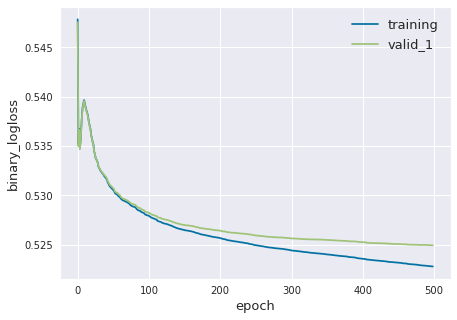

In [38]:
md.plot_train_info()

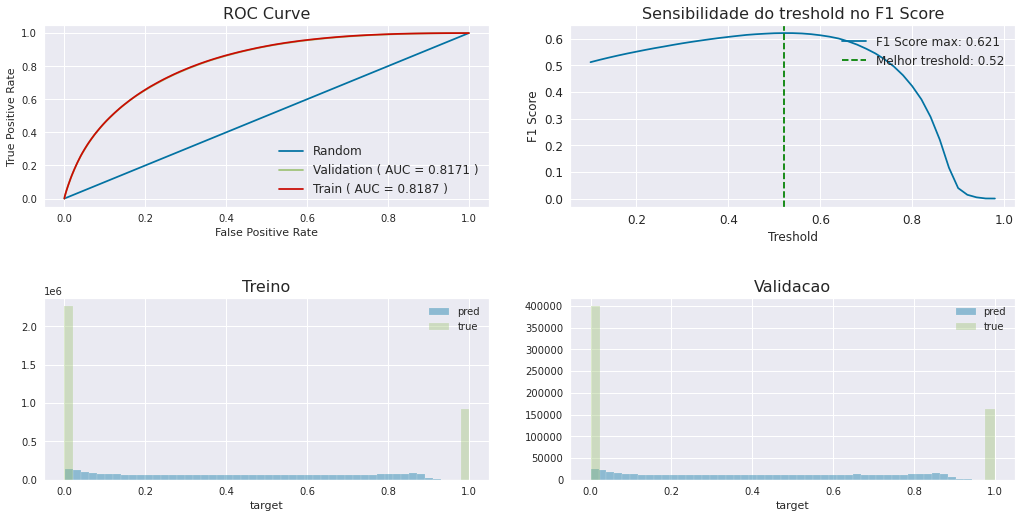

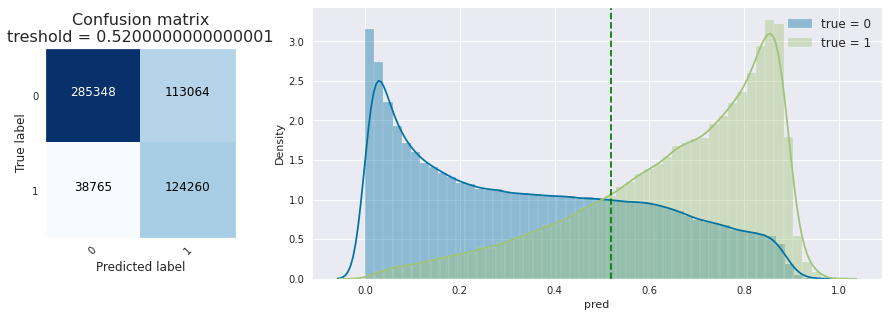


              precision    recall  f1-score   support

           0       0.88      0.72      0.79    398412
           1       0.52      0.76      0.62    163025

    accuracy                           0.73    561437
   macro avg       0.70      0.74      0.71    561437
weighted avg       0.78      0.73      0.74    561437



In [43]:
ytrain_pred = model.predict(Xtrain)
yval_pred = model.predict(Xval)
md.eval_binary(ytrain['target'], ytrain_pred, yval['target'], yval_pred)

In [41]:
md.treshold

0.5200000000000001

In [45]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
ytrain_pred = model.predict(Xtrain)
yval_pred = model.predict(Xval)

if type(ytrain) == pd.Series:
    ytrain = ytrain.values
if type(yval) == pd.Series:
    yval = yval.values

print('\n ============== Resumo metricas ============== \n')
print('TREINO:\n')
metrics_train = md.metrics_print(
    ytrain.values.clip(0, None), 
    ytrain_pred.clip(0, None), 
    metrics
)

print('\nVALIDACAO:\n')
metrics_val = md.metrics_print(
    yval.values.clip(0, None), 
    yval_pred.clip(0, None), 
    metrics
)

print('\n')  


 ============== Resumo metricas ============== 

TREINO:

|   Accuracy |   Precision |   Recall |     F1 |   ROC_AUC |
|------------|-------------|----------|--------|-----------|
|     0.7308 |      0.5256 |   0.7643 | 0.6229 |    0.7407 |

VALIDACAO:

|   Accuracy |   Precision |   Recall |     F1 |   ROC_AUC |
|------------|-------------|----------|--------|-----------|
|     0.7296 |      0.5236 |   0.7622 | 0.6208 |    0.7392 |




In [53]:
from datetime import datetime
import pytz
import joblib
exp_name = datetime.now(tz=pytz.timezone('America/Sao_Paulo')).strftime('%Y%m%d-%H%M%S')
path_to_experiment = os.path.dirname(os.getcwd()) + f'/artifacts/staging/{exp_name}'
os.mkdir(path_to_experiment)

model_path = f'{path_to_experiment}/model.joblib'
fe_pipeline_path = f'{path_to_experiment}/fe_pipeline.joblib'
fs_pipeline_path = f'{path_to_experiment}/fs_pipeline.joblib'

joblib.dump(pipeline, fe_pipeline_path)

joblib.dump(fs_pipeline, fs_pipeline_path)

joblib.dump(model, model_path)

['/home/jupyter/poc-gpa-churn-italo/artifacts/staging/20220520-201927/model.joblib']